Mario Coronado (100496637) + Carlos Casanova (100472714)
# HOMEWORK 1

## Problem Description 
Multi-period production planning and distribution for a pharmaceutical company. 

The company needs to optimize the production, storage, and distribution of **four products** (Painkillers, Antibiotics, Vaccines, and Antivirals) through a supply chain consisting of **three laboratories** (Leganes, Zaragoza, Malaga) and **four pharmacies** (Madrid, Barcelona, Sevilla and Valencia) over the period of one year divided in **four quarters** (Q1, Q2, Q3, Q4).

The **objective** is to minimize the total cost, which will be divided into:
- Production Cost. It is the cost related to the production of the different products in each laboratory.
- Storage Cost. Cost of storing products over a quarter in every different pharmacy. 
- Transportation. Cost related to the transportation between laboratories and pharmacies for each quarter.

Moreover, we need to take into account a series of **constraints** to make the problem more realistic: laboratories have limited production capacities, while the pharmacies have constrained storage capacities. Demand for each product must be met at every pharmacy in every quarter. The inventory levels are defined as the quantity of products left at the end of each quarter, which have to take into account local demand.

Taking into account all these considerations the challenge becomes determining: the best quantities of production at each laboratory, the transportation quantities between laboratories and pharmacies, and the inventory levels maintained at pharmacies. All these needs to be computed while also taking into account the current time period, which will finally result into a total of **304 variables**. 

At every moment a **Data Creation Logic** has been followed to obtain the csv files containing the problem data:
- Transportation costs vary depending on the distance between laboratories and pharmacies (i.e., the cost of transport between Leganes and Madrid is smaller than Leganes to Barcelona, for example)
- Pharmacies represent endpoints with limited storage, allowing us to implement logistic constraints. Bigger cities have more storage capacity.
- Laboratories can produce and supply different pharmacies but are limited by capacity.<br></br>

The main critical question that comes to our mind with this optimization model aims is:

**How should the company allocate production, inventory, and transportation resources over time to minimize costs while meeting demand and respecting capacity constraints?**


--------------------

In [ ]:
# IMPORTS 
import numpy as np
import pandas as pd
from pyomo.environ import *
from pyomo.opt import SolverFactory
from io import StringIO # for preview of model.display()

--------------------

## Definition of Sets
- **I**: Set of **Products**: 'Painkiller', 'Antibiotic', 'Vaccine', 'Vitamin', 'Antiviral'

- **J**: Set of production **Laboratories**: 'Leganes_Plant', 'Zaragoza_Plant', 'Malaga_Plant'

- **K**: Set of **Pharmacies**: 'Madrid_F', 'Barcelona_F', 'Sevilla_F', 'Valencia_F'

- **T**: Set of time periods: **Quarters** of a year

In [2]:
# Create a Pyomo model
model = ConcreteModel(doc = 'Multi-period Production / Distribution Planning for a Pharmaceutical Company')

model.I = Set(initialize=['Painkiller', 'Antibiotic', 'Vaccine', 'Antiviral'], doc = 'Products')

model.J = Set(initialize=['Leganes_Plant', 'Zaragoza_Plant', 'Malaga_Plant'], doc = 'Laboratories')

model.K = Set(initialize=['Madrid_F', 'Barcelona_F', 'Sevilla_F', 'Valencia_F'], doc = 'Pharmacies')

model.T = Set(initialize=['Q1', 'Q2', 'Q3', 'Q4'], doc = 'Quarters')

--------------------

## Definition of Parameters

Parameter data is stored in its respective CSV to maintain order, coherence, and consistency, so we extract the data from there.

- **Production Cost** per gram of each Product in each Laboratory.

    $c_{i,j}$

In [3]:
# Load CSV data
production_cost_df = pd.read_csv('production_costs.csv')

# Convert DataFrame to dictionary with (product, laboratory) as keys
production_cost_dict = production_cost_df.set_index(['product','laboratory'])['production_cost'].to_dict()

# Within NonNegativeReals
model.c = Param(model.I, model.J, initialize=production_cost_dict, within=NonNegativeReals, doc = 'Production Cost')

In [4]:
production_cost_df.head()

,product,laboratory,production_cost
0,Painkiller,Leganes_Plant,1.046
1,Painkiller,Zaragoza_Plant,3.860
2,Painkiller,Malaga_Plant,1.124
3,Antibiotic,Leganes_Plant,3.904
4,Antibiotic,Zaragoza_Plant,3.596


- **Production Capacity** at each Laboratory.

    $productionCapacity_{j}$

In [5]:
# Load CSV data
production_capcity_df= pd.read_csv('production_capacity.csv')

# Convert DataFrame to dictionary with (Laboratoy) as keys
production_capacity_dict = production_capcity_df.set_index(['Laboratory'])['production_capacity'].to_dict()

# Within NonNegativeReals
model.productionCapacity = Param(model.J, initialize=production_capacity_dict, within=NonNegativeReals, doc = 'Production Capacity')


In [6]:
production_capcity_df.head()

,Laboratory,production_capacity
0,Leganes_Plant,600
1,Zaragoza_Plant,800
2,Malaga_Plant,1000


- **Transportation Cost** for each gram of product from a Laboratory to a Pharmacy.

    $t_{i,j,k}$

In [7]:
# Load CSV data
transport_cost_data = pd.read_csv('transport_cost.csv')

# Convert DataFrame to dictionary with (product, facility, pharmacy) as keys
transport_cost_dict = transport_cost_data.set_index(['product','laboratory','pharmacy'])['transport_cost'].to_dict()

# Within NonNegativeReals
model.t = Param(model.I, model.J, model.K, initialize=transport_cost_dict, within=NonNegativeReals, doc = 'Transport Cost')


In [8]:
transport_cost_data.head()

,product,laboratory,pharmacy,transport_cost
0,Painkiller,Leganes_Plant,Madrid_F,0.9
1,Painkiller,Leganes_Plant,Barcelona_F,2.0
2,Painkiller,Leganes_Plant,Sevilla_F,2.1
3,Painkiller,Leganes_Plant,Valencia_F,1.8
4,Painkiller,Zaragoza_Plant,Madrid_F,2.0


- **Demand** at each Pharmacy for each product for each quarter of the year.

    $demand_{i,k,t}$

In [9]:
# Load CSV data
demand_data = pd.read_csv('demand.csv')

# Convert DataFrame to dictionary with (product, pharmacy, quarter) as keys
demand_dict = demand_data.set_index(['product', 'pharmacy', 'quarter'])['demand'].to_dict()

# Within NonNegativeReals
model.demand = Param(model.I, model.K, model.T, initialize=demand_dict, within=NonNegativeReals, doc = 'Product Demand')

In [10]:
demand_data.head()

,product,pharmacy,quarter,demand
0,Painkiller,Madrid_F,Q1,131
1,Painkiller,Madrid_F,Q2,136
2,Painkiller,Madrid_F,Q3,142
3,Painkiller,Madrid_F,Q4,102
4,Painkiller,Barcelona_F,Q1,111


- **Storage Cost** per unit of Product in the inventory at each Pharmacy.

    $sC_{k}$

In [11]:
# Load CSV data
storage_cost_data = pd.read_csv('storage_cost.csv')

# Convert DataFrame to dictionary with (pharmacy) as keys
storage_cost_dict = storage_cost_data.set_index(['pharmacy'])['storage_cost'].to_dict()

# Within NonNegativeReals
model.sC = Param(model.K, initialize=storage_cost_dict, within=NonNegativeReals, doc = 'Storage Cost')


In [12]:
storage_cost_data.head()

,pharmacy,storage_cost
0,Madrid_F,0.58
1,Barcelona_F,0.60
2,Sevilla_F,0.40
3,Valencia_F,0.50


- **Storage Capacity** at each Pharmacy.

    $storageCapacity_{k}$

In [13]:
# Load CSV data
storage_capacity_data = pd.read_csv('storage_capacity.csv')

# Convert DataFrame to dictionary with (pharmacy) as keys
storage_capacity_dict = storage_capacity_data.set_index(['pharmacy'])['storage_capacity'].to_dict()

# Within NonNegativeReals
model.storageCapacity = Param(model.K, initialize=storage_capacity_dict, within=NonNegativeReals, doc = 'Storage Capacity')

In [14]:
storage_capacity_data.head()

,pharmacy,storage_capacity
0,Madrid_F,200
1,Barcelona_F,100
2,Sevilla_F,50
3,Valencia_F,90


--------------------

## Decision Variables

The amounts are in grams; therefore, we use the Non-Negative Reals for all variables, as they are continuous and cannot be negative.

- **Production Quantities**: Amount (grams) of each product to be produced at a Laboratory at the start of the quarter.

    $x_{ i,j,t}$


In [15]:
# Within Non-Negative-Reals
model.x = Var(model.I, model.J, model.T, within=NonNegativeReals, doc = 'Production Quantities(g)')

- **Inventory Levels**: Inventory of each product quantity (grams) at Pharmacy at the end of a quarter.

    $y_{ i,k,t}$

In [16]:
# Within Non-Negative-Reals
model.y = Var(model.I, model.K, model.T, within=NonNegativeReals, doc = 'Inventory levels on Pharmacies')

- **Transportation Quantities**: Amount (grams) for each product transported from a Laboratory to a Pharmacy in a specific quarter.

    $z_{ i,j,k,t}$

In [17]:
# Within Non-Negative-Reals
model.z = Var(model.I, model.J, model.K, model.T, within=NonNegativeReals, doc = 'Transportation Quantities(g)')

--------------------

## Constraints

- **Inventory Balance**: Ensures that the inventory at each pharmacy for a product at the end of a quarter equals the previous quarter's inventory plus incoming shipments minus demand. For Q1, initial inventory is assumed to be zero.

    $y_{i,k,t} = y_{i,k,t - 1} + \sum_{j}^{}z_{i,j,k,t} - demand_{i,k,t} \quad \forall i,k,t$

In [18]:
def inventory_balance_rule(model, i, k, t):
    if t == 'Q1':
        # Assume an initial inventory level = 0
        initial_inventory = 0

        return model.y[i, k, t] == initial_inventory + sum(model.z[i, j, k, t] for j in model.J) - model.demand[i, k, t]
    else:
        prev_t = model.T.prev(t)
        return  model.y[i, k, t] == model.y[i, k, prev_t] + sum(model.z[i, j, k, t] for j in model.J) - model.demand[i, k, t]
    
model.InventoryBalanceConstraint = Constraint(model.I, model.K, model.T, rule=inventory_balance_rule)


- **Demand Satisfaction**: Ensures that the total supply of each product on each Pharmacy meets or exceeds its demand in each time period. Supply as the inventory and the incoming I from the J

    $ y_{i,k,t-1} + \sum_{j}^{}z_{i,j,k,t} \ge demand_{i,k,t} \quad \forall i,k,t$

In [19]:
def demand_satisfaction_rule(model, i, k, t):
    if t == 'Q1': # initial inventory for Q1 is assumed to be 0
        return sum(model.z[i, j, k, t] for j in model.J) >= model.demand[i, k, t]
    else: 
        prev_t = model.T.prev(t)
        return model.y[i, k, prev_t] + sum(model.z[i, j, k, t] for j in model.J) >= model.demand[i, k, t]

model.DemandSatisfactionConstraint = Constraint(model.I, model.K, model.T, rule=demand_satisfaction_rule)

- **Production Distribution**: Ensures that the quantity of each product produced at each laboratory is at least as much as the total amount shipped to all K.

    $x_{ i,j,t} \ge \sum_{k}^{}z_{ i,j,k,t} \quad \forall i,j,t$

In [20]:
def production_distribution_rule(model, i, j, t):
    return sum(model.z[i, j, k, t] for k in model.K) <= model.x[i, j, t]

model.ProductionDistributionConstraint = Constraint(model.I, model.J, model.T, rule=production_distribution_rule)

- **Production Capacity**: Limits the total production at each laboratory to its maximum production capacity for each quarter.

    $\sum_{i}^{}x_{i,j,t} \le productionCapacity_{j} \quad \forall j,t$

In [21]:
def production_capacity_rule(model, j, t):
    return sum(model.x[i, j, t] for i in model.I) <= model.productionCapacity[j]

model.ProductionCapacityConstraint = Constraint(model.J, model.T, rule=production_capacity_rule)

- **Storage Capacity**: Restricts the total inventory at each pharmacy to not exceed its storage capacity in each time period.

    $\sum_{i}^{}y_{i,k,t} \le storageCapacity_{k} \quad \forall k,t $

In [22]:
def storage_capacity_rule(model, k, t):
    return sum(model.y[i, k, t] for i in model.I) <= model.storageCapacity[k]

model.StorageCapacityConstraint = Constraint(model.K, model.T, rule=storage_capacity_rule)

--------------------

## Objective Function

**Minimize** total costs associated with:
- Production
- Storage (inventory holding)
- Transportation (shipping I from J to K)

$min(\sum_{i,j,t}^{}c_{i,j}x_{i,j,t} + \sum_{i,k,t}^{}sC_{k}y_{i,k,t} + \sum_{i,j,k,t}^{}t_{i,j,k}z_{i,j,k,t})$

In [23]:
# Define the objective rule
def total_cost_rule(model):
    production_cost = sum((model.c[i, j] * model.x[i, j, t]) for i in model.I for j in model.J for t in model.T)

    storage_cost = sum((model.sC[k] * model.y[i, k, t]) for i in model.I for k in model.K for t in model.T)

    transportation_cost = sum((model.t[i, j, k] * model.z[i, j, k, t]) for i in model.I for j in model.J for k in model.K for t in model.T)

    total_cost = production_cost + storage_cost + transportation_cost
    return total_cost

# Add the objective function to the model
model.totalCost = Objective(rule=total_cost_rule, sense=minimize)

# Dual problem
model.dual = Suffix(direction=Suffix.IMPORT)


--------------------

## Solve

In [24]:
# Solver
solver = SolverFactory('gurobi')
solver.solve(model, tee=True)

# Display results
#model.display()

Set parameter Username
Set parameter LicenseID to value 2583397
Academic license - for non-commercial use only - expires 2025-11-13
Read LP format model from file C:\Users\usuario\AppData\Local\Temp\tmpootyk_t5.pyomo.lp
Reading time = 0.01 seconds
x1: 204 rows, 304 columns, 896 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 5 4500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 6 logical processors, using up to 6 threads

Non-default parameters:
QCPDual  1

Optimize a model with 204 rows, 304 columns and 896 nonzeros
Model fingerprint: 0x3608e81f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 1e+03]
Presolve removed 48 rows and 48 columns
Presolve time: 0.00s
Presolved: 156 rows, 256 columns, 800 nonzeros

Iteration    Objective       Primal Inf.

{'Problem': [{'Name': 'x1', 'Lower bound': 31049.144, 'Upper bound': 31049.144, 'Number of objectives': 1, 'Number of constraints': 204, 'Number of variables': 304, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 304, 'Number of nonzeros': 896, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.003000020980834961', 'Error rc': 0, 'Time': 0.6832752227783203}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

#### Minimum Total Cost Solution

In [ ]:
# To ensure the model.display output does not show all component and just a preview, we will redirect the output and process it.
buffer = StringIO()
model.display(ostream=buffer)
output = buffer.getvalue()
buffer.close()

# Display only the first 15
print("\n".join(output.splitlines()[:15]) + "\n") 


Model unknown

  Variables:
    x : Production Quantities(g)
        Size=48, Index=I*J*T
        Key                                    : Lower : Value : Upper : Fixed : Stale : Domain
         ('Antibiotic', 'Leganes_Plant', 'Q1') :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Antibiotic', 'Leganes_Plant', 'Q2') :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Antibiotic', 'Leganes_Plant', 'Q3') :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Antibiotic', 'Leganes_Plant', 'Q4') :     0 :   7.0 :  None : False : False : NonNegativeReals
          ('Antibiotic', 'Malaga_Plant', 'Q1') :     0 : 394.0 :  None : False : False : NonNegativeReals
          ('Antibiotic', 'Malaga_Plant', 'Q2') :     0 : 336.0 :  None : False : False : NonNegativeReals
          ('Antibiotic', 'Malaga_Plant', 'Q3') :     0 : 361.0 :  None : False : False : NonNegativeReals
          ('Antibiotic', 'Malaga_Plant', 'Q4') :     0 : 388.0 :  None :

In [ ]:

# Total optimized Cost
model.totalCost.display()


The **optimal total cost** for the problem is 31049.144

Let's interpret the results by gathering the optimal solution variables in a pandas dataframe:

In [42]:
production_data = []
for i in model.I:
    for j in model.J:
        for t in model.T:
            production_data.append({
                'product': i,
                'Laboratory': j,
                'Quarter': t,
                'Quantity_Produced': model.x[i, j, t].value
            })
production_quantities_df = pd.DataFrame(production_data)

### 2. Inventory Levels y[i,k,t]:
inventory_data = []
for i in model.I:
    for k in model.K:
        for t in model.T:
            inventory_data.append({
                'product': i,
                'Pharmacy': k,
                'Quarter': t,
                'Inventory': model.y[i, k, t].value
            })
inventory_df = pd.DataFrame(inventory_data)

## 3. Transportation Quantities z[i,j,k,t]:
transportation_data = []
for i in model.I:
    for j in model.J:
        for k in model.K:
            for t in model.T:
                transportation_data.append({
                    'product': i,
                    'Laboratory': j,
                    'Pharmacy': k,
                    'Quarter': t,
                    'Transported_Quantity': model.z[i, j, k, t].value
                })
transportation_df = pd.DataFrame(transportation_data)

In [43]:
production_quantities_df.head(3)

,product,Laboratory,Quarter,Quantity_Produced
0,Painkiller,Leganes_Plant,Q1,329.0
1,Painkiller,Leganes_Plant,Q2,415.0
2,Painkiller,Leganes_Plant,Q3,372.0


In [44]:
inventory_df.head(3)

,product,Pharmacy,Quarter,Inventory
0,Painkiller,Madrid_F,Q1,0.0
1,Painkiller,Madrid_F,Q2,0.0
2,Painkiller,Madrid_F,Q3,0.0


In [45]:
transportation_df.head(3)

,product,Laboratory,Pharmacy,Quarter,Transported_Quantity
0,Painkiller,Leganes_Plant,Madrid_F,Q1,131.0
1,Painkiller,Leganes_Plant,Madrid_F,Q2,136.0
2,Painkiller,Leganes_Plant,Madrid_F,Q3,142.0


## Result Analysis

#### Production Quantities

In [46]:
production_quantities_df.groupby(['product', 'Laboratory'])['Quantity_Produced'].sum().reset_index() # aggregate quarters

,product,Laboratory,Quantity_Produced
0,Antibiotic,Leganes_Plant,7.0
1,Antibiotic,Malaga_Plant,1479.0
...,...,...,...
10,Vaccine,Malaga_Plant,1432.0
11,Vaccine,Zaragoza_Plant,491.0


In [47]:
production_quantities_df.groupby(['Laboratory'])['Quantity_Produced'].sum().reset_index() # aggregate quarters and products

,Laboratory,Quantity_Produced
0,Leganes_Plant,2400.0
1,Malaga_Plant,4000.0
2,Zaragoza_Plant,1592.0


* For this analysis, we grouped the data by quarters to examine the overall production of products throughout the year for each laboratory and to grasp a broader view of production. Additionally, we grouped by laboratory to assess each laboratory total output, finding that two laboratories are currently operating at maximum production capacity.

* The laboratory in Malaga is the highest producer overall, operating at full capacity, producing 1,000 products per quarter—its maximum possible output. This may be due to its central location with the pharmacies (Valencia, Sevilla, Madrid), which allows it to distribute to most pharmacies at lower costs and to produce products at reduced production costs as well. 

* It is interesting to look that Leganes is the leading producer of painkillers each quarter, though it does not produce any vaccines. This suggests that the cost of vaccine production and transportation is significantly higher than what other facilities can offer, whereas Leganes specializes as the most cost-effective producer of painkillers. Like Malaga, it is also operating at full capacity, producing 600 products per quarter, primarily focusing on painkillers. However, this focus on painkillers limits its capacity to supply vaccines to Madrid, where transportation costs would be lower than for other laboratories delivering vaccines to Madrid.

* Furthermore, across all quarters, Leganés produces only 7 grams of antibiotics. In reality, this is highly inefficient, as initiating a production process in a laboratory for such a small quantity is neither optimal nor cost-effective. Therefore, it may be beneficial to introduce additional constraints on production batch sizes to improve efficiency.

#### Inventory Quantity

In [48]:
inventory_df['Inventory'].sum() # sum all inventories at the end of each quarters

np.float64(0.0)

* None of the pharmacies have any inventory left at the end of the quarter after meeting the quarterly demand.

* The optimal solution does not retain any of the transported products for the following quarter. Instead, it follows a Just-in-Time production model, where all demand is met with products produced within that quarter. This approach ensures no products are saved at the end of the quarter. In the next part of the assignment, it would be interesting to introduce incentives for pharmacies to retain some products for the next quarter. Currently, there is no benefit in ordering more than what is required for a single quarter because transport costs remain the same regardless of transporting additional quarter's worth of products. Therefore, storing products only adds unnecessary costs.

#### Transportation Quantities

In [49]:
transportation_df.groupby(['Laboratory', 'Pharmacy'])['Transported_Quantity'].sum().reset_index() # aggregate by quarters

,Laboratory,Pharmacy,Transported_Quantity
0,Leganes_Plant,Barcelona_F,521.0
1,Leganes_Plant,Madrid_F,1009.0
...,...,...,...
10,Zaragoza_Plant,Sevilla_F,0.0
11,Zaragoza_Plant,Valencia_F,120.0


* For the analysis we aggregated by product and quarter, gaining a broader view of the interconnections between laboratories and pharmacies, independent of specific products and across the entire year. This highlights the geographical relationships influencing transportation costs and production costs. 

* For instance, Leganés primarily supplies Madrid, Malaga focuses on Seville, and Zaragoza on Barcelona. Valencia, however, is supplied by both Leganés and Malaga. This is because, while Leganés is closer, it prioritizes meeting demand in Madrid, while Malaga offers the lowest production costs. Unlike other laboratories, which are each linked to a specific nearby pharmacy, Valencia's demand is split between the closest and most cost-effective options.

* Note that Zaragoza does not supply Seville or Madrid, as it focuses most of its efforts on Barcelona, its nearest location. Likewise, Malaga does not supply Barcelona, representing the high costs of transporting products over long distances across Spain, which is not cost-effective.

--------------------

## Sensitivities Analysis
In this analysis we are going to study how the solution to our problem responds to changes in each of its constraints, identifying in which of them the optimal solution depends on the most.

In [ ]:
# Redirect dual display output to a buffer, to just show a preview of dual
buffer = StringIO()
model.dual.display(ostream=buffer)
output = buffer.getvalue()
buffer.close()

print("\n".join(output.splitlines()[:10]))

AttributeError: 'ConcreteModel' object has no attribute 'dual'

In [55]:
###############################################################################
# Convert DUAL values to a DATAFRAME to easse visualization and interpretation
###############################################################################

if hasattr(model, 'dual'):
    duals_data = []

    # Inventory Balance Constraint Duals
    for i in model.I:
        for k in model.K:
            for t in model.T:
                constraint = model.InventoryBalanceConstraint[i, k, t]
                if constraint in model.dual:
                    duals_data.append({
                        'Constraint_Type': 'InventoryBalance',
                        'Product': i,
                        'Pharmacy': k,
                        'Quarter': t,
                        'Dual_Value': model.dual[constraint]
                    })

    # Demand Satisfaction Constraint Duals
    for i in model.I:
        for k in model.K:
            for t in model.T:
                constraint = model.DemandSatisfactionConstraint[i, k, t]
                if constraint in model.dual:
                    duals_data.append({
                        'Constraint_Type': 'DemandSatisfaction',
                        'Product': i,
                        'Pharmacy': k,
                        'Quarter': t,
                        'Dual_Value': model.dual[constraint]
                    })

    # Production Distribution Constraint Duals
    for i in model.I:
        for j in model.J:
            for t in model.T:
                constraint = model.ProductionDistributionConstraint[i, j, t]
                if constraint in model.dual:
                    duals_data.append({
                        'Constraint_Type': 'ProductionDistribution',
                        'Product': i,
                        'Laboratory': j,
                        'Quarter': t,
                        'Dual_Value': model.dual[constraint]
                    })

    # Production Capacity Constraint Duals
    for j in model.J:
        for t in model.T:
            constraint = model.ProductionCapacityConstraint[j, t]
            if constraint in model.dual:
                duals_data.append({
                    'Constraint_Type': 'ProductionCapacity',
                    'Laboratory': j,
                    'Quarter': t,
                    'Dual_Value': model.dual[constraint]
                })

    # Storage Capacity Constraint Duals
    for k in model.K:
        for t in model.T:
            constraint = model.StorageCapacityConstraint[k, t]
            if constraint in model.dual:
                duals_data.append({
                    'Constraint_Type': 'StorageCapacity',
                    'Pharmacy': k,
                    'Quarter': t,
                    'Dual_Value': model.dual[constraint]
                })

    duals_df = pd.DataFrame(duals_data)


In [56]:
duals_df[duals_df['Constraint_Type'] == 'InventoryBalance'].head(3) # filter by Constraints. We might find some na's in the df, 
                                                                    # because in some cases the constraint does not take all sets

,Constraint_Type,Product,Pharmacy,Quarter,Dual_Value,Laboratory
0,InventoryBalance,Painkiller,Madrid_F,Q1,-2.218,NaN
1,InventoryBalance,Painkiller,Madrid_F,Q2,-2.218,NaN
2,InventoryBalance,Painkiller,Madrid_F,Q3,-2.218,NaN


In [57]:
duals_df[duals_df['Constraint_Type'] == 'DemandSatisfaction'].head(3)

,Constraint_Type,Product,Pharmacy,Quarter,Dual_Value,Laboratory
64,DemandSatisfaction,Painkiller,Madrid_F,Q1,0.0,NaN
65,DemandSatisfaction,Painkiller,Madrid_F,Q2,0.0,NaN
66,DemandSatisfaction,Painkiller,Madrid_F,Q3,0.0,NaN


In [58]:
duals_df[duals_df['Constraint_Type'] == 'ProductionDistribution'].head(3)

,Constraint_Type,Product,Pharmacy,Quarter,Dual_Value,Laboratory
128,ProductionDistribution,Painkiller,NaN,Q1,-1.318,Leganes_Plant
129,ProductionDistribution,Painkiller,NaN,Q2,-1.318,Leganes_Plant
130,ProductionDistribution,Painkiller,NaN,Q3,-1.318,Leganes_Plant


In [59]:
duals_df[duals_df['Constraint_Type'] == 'ProductionCapacity'].head(3)

,Constraint_Type,Product,Pharmacy,Quarter,Dual_Value,Laboratory
176,ProductionCapacity,NaN,NaN,Q1,-0.272,Leganes_Plant
177,ProductionCapacity,NaN,NaN,Q2,-0.272,Leganes_Plant
178,ProductionCapacity,NaN,NaN,Q3,-0.272,Leganes_Plant


In [60]:
duals_df[duals_df['Constraint_Type'] == 'StorageCapacity'].head(3)

,Constraint_Type,Product,Pharmacy,Quarter,Dual_Value,Laboratory
188,StorageCapacity,NaN,Madrid_F,Q1,0.0,NaN
189,StorageCapacity,NaN,Madrid_F,Q2,0.0,NaN
190,StorageCapacity,NaN,Madrid_F,Q3,0.0,NaN


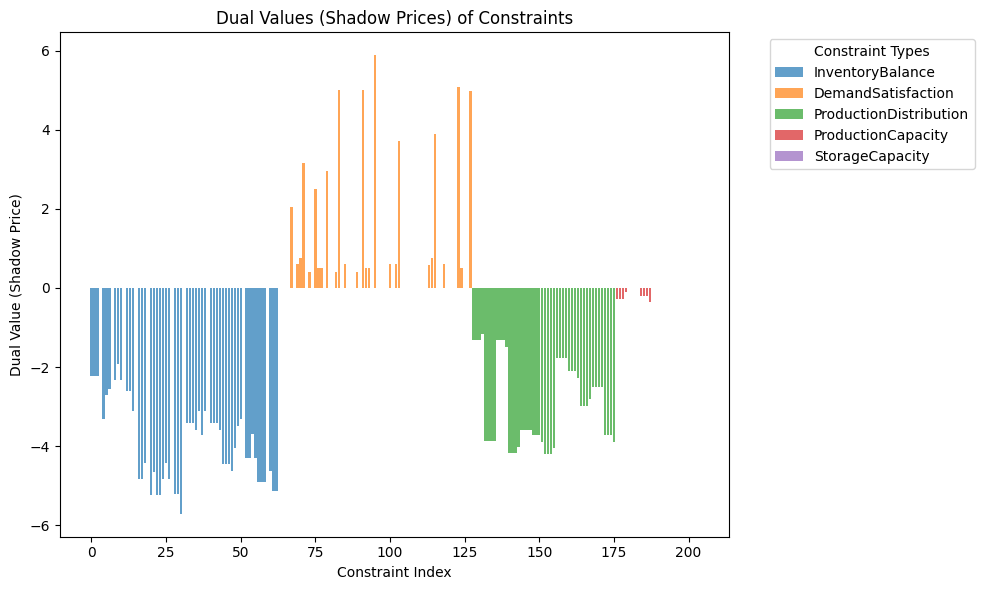

In [61]:
import matplotlib.pyplot as plt

# Create a bar plot to visualize dual values for each constraint
# Group by constraint type and plot the dual values
plt.figure(figsize=(10, 6))

# Create a bar plot for each constraint type
constraint_types = duals_df['Constraint_Type'].unique()
for constraint_type in constraint_types:
    subset = duals_df[duals_df['Constraint_Type'] == constraint_type]
    plt.bar(subset.index, subset['Dual_Value'], label=constraint_type, alpha=0.7)

plt.xlabel('Constraint Index')
plt.ylabel('Dual Value (Shadow Price)')
plt.title('Dual Values (Shadow Prices) of Constraints')
plt.legend(title='Constraint Types', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



From the plot we can interpret the following: 
- **Inventory Balance**. Its dual negative value trend means that if we allowed more flexibility in inventory levels the total cost would decrease. This could be better explained recurring to the mathematical formulation of our problem, taking into account that our constraint has the form: <br></br>
<code> model.y[i, k, t] == initial_inventory + sum(model.z[i, j, k, t] for j in model.J) - model.demand[i, k, t] </code>
    - For example, the demand of Painkiller in Valencia pharmacy in Q3 our dual value is -3.118. If the demand for Painkiller at Valencia Pharmacy in Q3 increases by one unit, the total cost would increase by 3.118, which could be reflected in a save in the cost of storage or transport. The RHS of the constraint decreases by 1 because demand is negative, and therefore the objective function would increase by 3.118 units.

- **Demand Satisfaction**. The overall positive dual value trend suggests that the supply cannot fully meet the demand without increasing costs. This could indicate that: product is in high demand, or supply (production or transportation) is insufficient to meet that demand at the given cost levels, and the system is optimizing its allocation of resources. 
    - For example, for the demand for Antiviral in the Valencia pharmacy at Q4 period our dual value is 4.974. Therefore, if we increase in 1 unit the demand of antiviral in Valencia in that period the cost would increase, this is direclty associated to the production cost of our obj. function.


- **Production Distribution**. The negative dual value for this constraint suggests that increasing the production quantity (i.e., increasing the production capacity at a specific facility) will decrease the total cost. Therefore, overproducing at a facility is not beneficial since the excess goes unused or incurs additional costs (e.g., storage cost). If we recurr to the math of the constraint: <br></br>
<code> sum(model.z[i, j, k, t] for k in model.K) <= model.x[i, j, t] </code>

    - With the results obtained we figured that Zaragoza Laboratory was completely using its maximum production capacity, therefore increasing the maximum production capacity by 1 would decrease significantly the total cost incurred.

    - For example, Painkiller production at Q4 from Zaragoza laboratory is -3.860. Then, if we increase in one unit the painkiller produced at Zaragoza in that period the objective function would increase in 3.86 units, since we allow for more products to be transported.
    
    Moreover, check that the value doesn't vary for the different periods, e.g.:

<table>
        <thead>
            <tr>
                <th>Constraint</th>
                <th>Product</th>
                <th>Quarter</th>
                <th>Dual Value</th>
                <th>Facility</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>ProductionDistribution</td>
                <td>Painkiller</td>
                <td>Q1</td>
                <td>-3.860</td>
                <td>Zaragoza_Plant</td>
            </tr>
            <tr>
                <td>ProductionDistribution</td>
                <td>Painkiller</td>
                <td>Q2</td>
                <td>-3.860</td>
                <td>Zaragoza_Plant</td>
            </tr>
            <tr>
                <td>ProductionDistribution</td>
                <td>Painkiller</td>
                <td>Q3</td>
                <td>-3.860</td>
                <td>Zaragoza_Plant</td>
            </tr>
            <tr>
                <td>ProductionDistribution</td>
                <td>Painkiller</td>
                <td>Q4</td>
                <td>-3.860</td>
                <td>Zaragoza_Plant</td>
            </tr>
        </tbody>
    </table>

It is interesting to see that the dual values are the same for all of the quarters, given that the sum of the demand of Painkiller through all the Pharmacies is different for each of the quarters.

- **Production Capacity and Storage Capacity**. A dual value of 0 (or ≈ 0) for this constraints could have specific implications (they are **not limiting**):
    - In production capacity constraint, dual values of 0 mean that increasing the production capacity wouldn't reduce production costs or improve the model's objective. <br></br>
    For example, at Q2 in Leganes Laboratory we have 0.0. Even if we increase by a unit the production capacity of Leganes, the total cost doesn't vary (we are not producing nor storing products although we could). Even, for those results which are different from 0, their value is so low that it could be overseen. 

    - In storage capacity constraint, dual values of 0 represent a lack of pressure to increase storage space (sufficient for the current amount of inventory).<br></br>
    For example, in Sevilla pharmacy at Q4 period our dual value is 0.00, which means that there's no impact in the objective function when increasing the storage by a unit, so no direct costs are related to these parameter unless we tighten its value. 

In conclusion, we can say that our key constraints - the ones that are limiting and have the greatest impact on our cost - are: Inventory Balance, Demand Satisfaction and Production Distribution.


--------------------

# Problem Modification

In order to modify the problem we recurr to conclusions based on previous result analysis, and ato give a more realistic approach. The main point is that our model does not retain any of the transported products for the following quarter. Instead, it follows a Just-in-Time production model, where all demand is met with products produced within that quarter. This approach ensures no products are saved at the end of the quarter. This is why many of our variables and constraints are focused towards encouraging the model towards keeping some level of inventory, and optimizing the transportation scenarios. 

What is the logic behind our modifications?
1. **Transport Trucks and Truck Capacity**. This is the main target to solve the "just-in-time" problem. With the use of truck variables and constraints we can encourage minimizing transport frequency and maximizing truck load, which is essentially keeping products in the pharmacies. 

2. **Number of Workers and Laboratory Workers**. Including the number of workers variable allows us to capture the impact of having more workers or adjusting workforce levels based on demand fluctuations. As a consequence, we needed to include the logic that each worker has a maximum productivity (e.g., can produce 50g of product per quarter), and we must check that this capacity is not excedeed since it would be unrealistic. We include human resource management into the supply chain.

3. **Start Product Production and Minimum/Maximum Run Production**. We ensure production batches meet a practical minimum size (e.g., it is not logic to produce only 1g. of a certain product). This will help us avoid inefficient runs (optimization and avoid unnecessary production costs) while still satisfying demand.

4. **Start Laboratory and Production Capacity**. In some cases it may be beneficial to reduce the total cost that some laboratories don't operate, helping us avoid unnecessary production costs. And assigning a fixed cost to starting a laboratory in a quarter to reflect reality, as simply being operational incurs some costs.

5. **Inventory Boxes**. We want to ensure inventory is stored in boxes of standard size (e.g., 5g units), we can transport inventory efficiently. Moreover, it doesn't make sense to just distribute inventory in very small amounts, like 1g. This also encourages the storage of inventory, since whole boxes may not be sold. 

After the addition of our integer and binary variables and constraints, we need to modify **objective function** which will include in addition to our main operational expenses (Production, Storage, and Transportation Costs):
- Truck Cost: fixed cost related to the transport of products between labs and pharmacies. We aim to reach an efficient use of trucks.
- Laboratory Costs: cost entailed in opening a laboratory in a given period.
- Labor Costs: cost associated to hiring employees in a quarter.

It is easy to see that after all this additional functionality the number of variables will increase, and therefore the same will happen with the complexity of the problem and time to reach a feasible solution. That is why we changed to **gurobi** Solver.



--------------------

## New Variables

- **Transport Trucks**: Number of trucks used to transport products from one laboratory to one pharmacy in a quarter. Using a truck incurs a fixed cost. 

$3 * 4 * 4 = 48 \quad variables$ 

$v_{ j,k,t}$


In [62]:
# Integer Variable
model.v = Var(model.J, model.K, model.T, within=NonNegativeIntegers, doc = 'Transport Trucks')

- **Number of Workers**: Total Number of Workers need to produce products in a laboratory in a quarter. There is a cost of hiring a worker in a laboratory for a quarter.

$3 * 4 = 12 \quad variables$

$w_{ j,t}$


In [63]:
# Integer Variable
model.w = Var(model.J, model.T, domain=NonNegativeIntegers, doc = 'Number of Workers')

- **Start Product Production**: Binary Variable determining weather the production of a product starts in a laboratory in a quarter.

$4*3*4 = 48 \quad variables$

$s_{ i,j,t}$


In [64]:
# Binary Variable
model.s = Var(model.I, model.J, model.T, domain=Binary, doc = 'Start Product Production')

- **Start Laboratory**: Binary Variable indicating if a Laboratory is operative in a quarter. Starting a Laboratory incurs a fixed cost.

$ 3 * 4 = 12 \quad variables$

$f_{ j,t}$


In [65]:
# Binary Variable
model.f = Var(model.J, model.T, domain=Binary, doc = 'Start Laboratory')

---------------

**Variables Remark**: Variables added $48 + 12 + 48 + 12 = 120$ New Variables plus 304 previous one. Makes a total of 424 variables in our problem wich makes it significantly complex

--------------------

## New Constraints

* **Truck Capacity** constraint ensures that the total quantity of products being shipped in a quarter does not exceed the total capacity of the trucks available between a laboratory and a pharmacy


    $\sum_{i \in I} z_{i,j,k,t} \leq v_{j,k,t} \times vC \quad \forall j, k, t$

In [66]:
vQ = 20 # fixed cost to start a truck to add in the objective

vC = 100 # truck max capacity

def truck_capcity_rule(model, j, k, t):
    return sum(model.z[i, j, k, t] for i in model.I) <= model.v[j, k, t] * vC

model.TruckCapacityConstraint = Constraint(model.J, model.K, model.T, rule=truck_capcity_rule)

* **Minimum Run Production** rule ensures that the production of any product from any laboratory during any quarter must meet or exceed a minimum batch size (set to 20).

    $x_{i,j,t} \geq \text{minimumBatch} \times s_{i,j,t} \quad \forall i, j, t$

* **Maximum Run Production** rule ensures that the production of any product from any laboratory during any quarter must not exceed the maximum batch size (set to 500).

    $x_{i,j,t} \leq \text{maximumBatch} \times s_{i,j,t} \quad \forall i, j, t$


In [67]:
minimumBatch = 20
maximumBatch = 500

def minimum_runProduction_rule(model, i, j, t):
    return model.x[i, j, t] >= minimumBatch * model.s[i, j, t]

def maximum_runProduction_rule(model, i, j, t):
    return model.x[i, j, t] <= maximumBatch * model.s[i, j, t]

model.MinimumBatchConstraint = Constraint(model.I, model.J, model.T, rule=minimum_runProduction_rule)

model.MaximumBatchConstraint = Constraint(model.I, model.J, model.T, rule=maximum_runProduction_rule)

* **Inventory Boxes** rule ensures that the inventory of each product must be stored in boxes of 5 units each. Creating a dummy variable $q_{i,k,t}$ to represent the number of boxes for each 5 grams of product at a pharmacy in a quarter. Added new 64 variables to the problem making it a total of 488 variables.

    $y_{i,k,t} = 5 \times q_{i,k,t} \quad \forall i, k, t$

In [68]:
# Integer Variable
model.q = Var(model.I, model.K, model.T, within=NonNegativeIntegers, doc = 'Number of Inventory Boxes (Dummy Var)') # 4 * 4 * 4 = 64 new variables

def inventory_boxes_rule(model, i, k, t):
    return model.y[i, k, t] == 5 * model.q[i, k, t]

model.InventoryBoxesConstraint = Constraint(model.I, model.K, model.T, rule=inventory_boxes_rule)

- **Production Capacity**: Limits the total production at each laboratory to its maximum production capacity for each quarter. **Additions:** Links the binary variable $f_{j,t}$ (Starts Laboratory) representing if the Laboratory is operating at a quarter, and 0 if it is not.

    $\sum_{i \in I} x_{i,j,t} \leq \text{productionCapacity}_{j} \times f_{j,t} \quad \forall j, t$

In [69]:
del model.ProductionCapacityConstraint # Deleting, to modify previous constraint

jC = 100 # laboratory start fixed cost to add in the objective

def production_capacity_rule(model, j, t):
    return sum(model.x[i, j, t] for i in model.I) <= model.productionCapacity[j] * model.f[j, t]

model.ProductionCapacityConstraint = Constraint(model.J, model.T, rule=production_capacity_rule)


- **Laboratory Workers**: Limits the total production at a laboratory to a certain level based on the new variable **number of workers**. The total amount of products manufactured at each laboratory cannot esceed the total production capacity determined by the number of workers assigned to that laboratory. A worker has a max number of products that can manufacture for a quarter (set to 50 grams).

    $\sum_{i \in I} x_{i,j,t} \leq \text{max\_production\_per\_w} \times w_{j,t} \quad \forall j, t$

In [70]:
max_production_per_w = 50
wC = 20 # Cost of hiring a worker for a quarter to add in the objective

def laboratory_workers_rule(model, j, t):
    return sum(model.x[i, j, t] for i in model.I) <= max_production_per_w * model.w[j, t]

model.LaboratoryWorkersConstraint = Constraint(model.J, model.T, rule=laboratory_workers_rule)

--------------------

## New Objective Function

**Minimize** total costs associated with:
- Production
- Storage (inventory holding)
- Transportation (shipping I to K)
- Trucks used fixed costs
- Laboratory start fixed costs
- Labor Cost (cost of hiring a worker)

$min(\sum_{i,j,t} c_{i,j} x_{i,j,t} + 
\sum_{i,k,t} sC_k y_{i,k,t} + 
\sum_{i,j,k,t} t_{i,j,k} z_{i,j,k,t} + 
\sum_{j,k,t} v_{j,k,t} vC + 
\sum_{j,t} (jC f_{j,t} + wC w_{j,t}))$

In [71]:
del model.totalCost # delete the previous objective to modify the new one

In [72]:
# Define the objective function
def total_cost_rule(model):
    production_cost = sum(model.c[i, j] * model.x[i, j, t] for i in model.I for j in model.J for t in model.T)
    
    storage_cost = sum(model.sC[k] * model.y[i, k, t] for i in model.I for k in model.K for t in model.T)

    transportation_cost = sum(model.t[i, j, k] * model.z[i, j, k, t] for i in model.I for j in model.J for k in model.K for t in model.T)
    
    truck_fixed_cost = sum(model.v[j, k, t] * vC for j in model.J for k in model.K for t in model.T)

    opening_lobaratory_fixed_cost = sum(jC * model.f[j, t] for j in model.J for t in model.T)

    labor_cost = sum(wC * model.w[j, t] for j in model.J for t in model.T)

    total_cost = production_cost + storage_cost + transportation_cost + truck_fixed_cost + opening_lobaratory_fixed_cost + labor_cost

    return total_cost

# Add the objective function to the model
model.totalCost = Objective(rule=total_cost_rule, sense=minimize)

In [73]:
del model.dual

In [74]:
# Solver
solver = pyomo.opt.SolverFactory('gurobi')
solver.solve(model)

{'Problem': [{'Name': 'x1', 'Lower bound': 43960.752, 'Upper bound': 43960.752, 'Number of objectives': 1, 'Number of constraints': 424, 'Number of variables': 488, 'Number of binary variables': 60, 'Number of integer variables': 184, 'Number of continuous variables': 304, 'Number of nonzeros': 1528, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '3.2330000400543213', 'Error rc': 0, 'Time': 3.5308430194854736}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

#### Optimal Total Cost Solution

In [75]:
model.totalCost()

43960.75200000001

The **optimal total cost** for the new problem is now 43960.752 increasing in comparison by 12911.608 throught the new added costs and constraints

In [ ]:
# Redirect model display output to a buffer, to just show a preview of model
buffer = StringIO()
model.display(ostream=buffer)
output = buffer.getvalue()
buffer.close()

print("\n".join(output.splitlines()[:10]))

Model unknown

  Variables:
    x : Production Quantities(g)
        Size=48, Index=I*J*T
        Key                                    : Lower : Value : Upper : Fixed : Stale : Domain
         ('Antibiotic', 'Leganes_Plant', 'Q1') :     0 :  27.0 :  None : False : False : NonNegativeReals
         ('Antibiotic', 'Leganes_Plant', 'Q2') :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Antibiotic', 'Leganes_Plant', 'Q3') :     0 :  38.0 :  None : False : False : NonNegativeReals
         ('Antibiotic', 'Leganes_Plant', 'Q4') :     0 :  36.0 :  None : False : False : NonNegativeReals


In [78]:
production_data = []
for i in model.I:
    for j in model.J:
        for t in model.T:
            production_data.append({
                'product': i,
                'Laboratory': j,
                'Quarter': t,
                'Quantity_Produced': model.x[i, j, t].value
            })
production_quantities_df = pd.DataFrame(production_data)

### 2. Inventory Levels y[i,k,t]:
inventory_data = []
for i in model.I:
    for k in model.K:
        for t in model.T:
            inventory_data.append({
                'product': i,
                'Pharmacy': k,
                'Quarter': t,
                'Inventory': model.y[i, k, t].value
            })
inventory_df = pd.DataFrame(inventory_data)

## 3. Transportation Quantities z[i,j,k,t]:
transportation_data = []
for i in model.I:
    for j in model.J:
        for k in model.K:
            for t in model.T:
                transportation_data.append({
                    'product': i,
                    'Laboratory': j,
                    'Pharmacy': k,
                    'Quarter': t,
                    'Transported_Quantity': model.z[i, j, k, t].value
                })
transportation_df = pd.DataFrame(transportation_data)

## 4. Number of Trucks v[j,k,t]:
trucks_data = []
for j in model.J:
    for k in model.K:
        for t in model.T:
            trucks_data.append({
                'Laboratory': j,
                'Pharmacy': k,
                'Quarter': t,
                'Trucks_Needed': model.v[j, k, t].value
            })
trucks_df = pd.DataFrame(trucks_data)

## 5. Number of Workers w[j,t]:
workers_data = []
for j in model.J:
    for t in model.T:
        workers_data.append({
            'Laboratory': j,
            'Quarter': t,
            'Workers_Needed': model.w[j, t].value
        })
workers_df = pd.DataFrame(workers_data)

## 6. Start Laboratory f[j,t]:
laboratory_data = []
for j in model.J:
    for t in model.T:
        laboratory_data.append({
            'Laboratory': j,
            'Quarter': t,
            'Open_Closed': model.f[j, t].value
        })
laboratory_df = pd.DataFrame(laboratory_data)

## Result Analysis

#### Production Quantities

In [79]:
production_quantities_df.groupby(['product', 'Laboratory'])['Quantity_Produced'].sum().reset_index() # aggregate quarters

,product,Laboratory,Quantity_Produced
0,Antibiotic,Leganes_Plant,101.0
1,Antibiotic,Malaga_Plant,1385.0
...,...,...,...
10,Vaccine,Malaga_Plant,1434.0
11,Vaccine,Zaragoza_Plant,489.0


In [80]:
production_quantities_df.groupby(['Laboratory'])['Quantity_Produced'].sum().reset_index() # aggregate quarters and products

,Laboratory,Quantity_Produced
0,Leganes_Plant,2381.0
1,Malaga_Plant,3928.0
2,Zaragoza_Plant,1683.0


* Thorugh the same analysis by aggregating data by quarters and then by products, we achieve a comprehensive view of production and distribution across the year.

* This results are a big improvement. For instance: No laboratory is operating at maximum production capacity, and product quantities are now more evenly distributed across laboratories throughout the year, a step toward a more realistic solution.

* With minimum and maximum batch constraints, inefficient production (e.g., small, wasteful batches like 7 units) has been eliminated. Production now only starts for batches of 20 units or more, enhancing cost efficiency and optimizing operations.

* Similar patterns show, with Leganés remaining the primary distributor of painkillers and Malaga leading in antibiotic production, owing to their lower costs for these products. And Malaga is the highest distributor, thanks to its high production capacity.

* The addition of binary variables to control production start, batches, and related constraints yields results that are both more realistic and operationally sound. While the total cost objective has increased slightly, the solution is more logical and closely aligned with real-world logistics and efficiencies.

#### Inventory Quantity

In [81]:
inventory_df['Inventory'].sum() # sum all inventory balances

np.float64(310.0)

In [82]:
inventory_df.groupby(['Pharmacy'])['Inventory'].sum().reset_index() # aggregate quarters

,Pharmacy,Inventory
0,Barcelona_F,220.0
1,Madrid_F,10.0
2,Sevilla_F,25.0
3,Valencia_F,55.0


* Another Great Results Improvement. The model no longer follows a strict Just-In-Time approach; it now recognizes that, in some cases, storing inventory at the pharmacy for one quarter is more cost-effective. When transportation costs are lower, pharmacies can partially fulfill the next quarter’s demand by storing inventory, optimizing long-term costs despite some storage expenses.

* The addition of truck variable with trucks capacity, fixed-cost and its constraints constraints has been impactful. Trucks have a maximum capacity, and each truck request incurs a fixed cost, leading to more efficient inventory decisions. For example, if a pharmacy requires 90 products from Leganés in Q1 and anticipates needing more in Q2, it’s more cost-effective to request 100 products (filling the truck) rather than incurring extra transportation costs in the next quarter. Where this can sometimes reduce the number of trucks needed.

* Note that Inventory is now stored in multiples of 5 due to a new constraint that requires products to be stored in boxes of 5 grams, ensuring no single items are stored. This addition makes the model more realistic by reflecting typical storage practices and results in more consistent and practical outcomes.

#### Transportation Quantity

In [83]:
transportation_df.groupby(['Laboratory', 'Pharmacy'])['Transported_Quantity'].sum().reset_index() # aggregate quarters

,Laboratory,Pharmacy,Transported_Quantity
0,Leganes_Plant,Barcelona_F,496.0
1,Leganes_Plant,Madrid_F,989.0
...,...,...,...
10,Zaragoza_Plant,Sevilla_F,0.0
11,Zaragoza_Plant,Valencia_F,186.0


* The interconnections between laboratories and pharmacies, as well as transportation quantities, remain similar to previous results.Distribution is slightly more spread out, yet the primary pattern holds: higher transportation quantities still occur between closer cities. Furhtermore, extreme cases remain unchanged, such as the impracticality of transporting from Malaga to Barcelona due to high distance.

#### Number of Trucks

In [84]:
trucks_df.groupby(['Laboratory', 'Pharmacy'])['Trucks_Needed'].sum().reset_index() # aggregate quarters

,Laboratory,Pharmacy,Trucks_Needed
0,Leganes_Plant,Barcelona_F,5.0
1,Leganes_Plant,Madrid_F,10.0
...,...,...,...
10,Zaragoza_Plant,Sevilla_F,0.0
11,Zaragoza_Plant,Valencia_F,2.0


* This results show the total number of trucks needed to transport products from a laboratory to a pharmacy. Completely correlated with the transportation quantities data, showing the interconnections between cities and laboratories, and the total product volumes transported on a different scale.

* It is interesting to see that the minimum number of trucks needed in a year from a laboratory to a pharmacy it is two. This suggests that even for low-demand routes, there is a need for multiple shipments, possibly due to batch sizes or periodic demand fluctuations, ensuring steady supply. Being a more realistic problem with the new added variable and constraints.

#### Number of Workers

In [85]:
workers_df.groupby(['Laboratory'])['Workers_Needed'].sum().reset_index() # aggregate quarters

,Laboratory,Workers_Needed
0,Leganes_Plant,48.0
1,Malaga_Plant,79.0
2,Zaragoza_Plant,34.0


* This analysis reveals the total number of workers required at each laboratory throughout the year, directly correlated with production quantities, as each worker has a maximum production capacity.

* Note that hiring a worker for a quarter incurs a cost, which is likely one of the key reasons explaining why Malaga has not hired additional workers to reach maximum production capacity, as it did in the previous problem with max production capacity. Instead, it appears more efficient to produce certain products at other locations with lower costs, making better use of available labor capacity and optimizing for transportation efficiencies with trucks.

* This approach provides a more realistic and cost-effective solution by distributing production in a way that maximizes labor and transport resources, yielding deeper insights into operational efficiency.


#### Laboratories

In [86]:
(laboratory_df['Open_Closed'] == 1).all().all() # check that all laboratories are open

np.True_

* By ensuring that all laboratories are open throughout all quarters, the model shows a fixed cost that is calculated as the laboratory's fixed cost multiplied by the number of laboratories and quarters. Having a starting point of the fixed costs in the objective of 100 * 4 * 3 = 1200